In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import pickle

from helpers.data import get_pdf_toy, read_in_data
from helpers.ansatz import q, get_factorial_cache, get_taylor_expanded_ansatz

In [2]:
plt.style.use('/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_full_notex.mplstyle')
device = "cpu"

In [3]:

outfile_name = f"thrust_2_3d"

save_dict = {}

with open(f"output/{outfile_name}_config", "rb") as ifile:
    save_dict["configs"] = pickle.load(ifile)
   
losses = np.load(f"output/{outfile_name}_losses.npy")
g_coeffs_log = np.load(f"output/{outfile_name}_g_coeffs.npy")
theta_log = np.load(f"output/{outfile_name}_theta.npy")


distribution = save_dict["configs"]["distribution"]
order_to_match = save_dict["configs"]["order_to_match"]
name = save_dict["configs"]["name"]
mstar = save_dict["configs"]["mstar"]
run_toy = save_dict["configs"]["run_toy"]

print(save_dict["configs"])

{'distribution': 'thrust', 'run_toy': False, 'order_to_match': 2, 'name': '3d', 'mstar': 1, 'init_random': True, 'init_at_answer': False, 'init_close_to_answer': False, 'learn_theta': True, 'ratio_loss': False, 'weighted_mse_loss': False, 'use_logbins': False, 'n_bins': 100, 't_min': 0, 't_max': 10, 'epochs': 20000, 'batch_size': 345, 'lr': 0.01, 'seed': 42, 'm': 2, 'n': 10, 'device': 'cuda'}


In [4]:
# Helper functions ofr plotting

max_M, max_N = g_coeffs_log[0].shape

factorial_cache_info = get_factorial_cache(max_M, max_N, mstar, device)




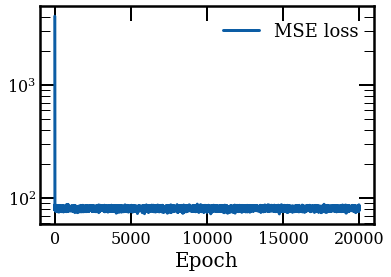

In [5]:


# Plot loss
plt.figure()
plt.plot(losses, label="MSE loss")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.show()



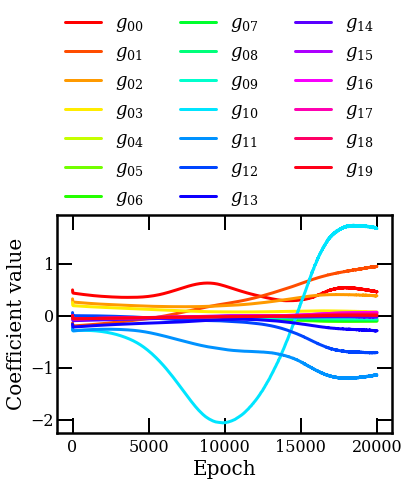

In [6]:


from matplotlib.pyplot import cm
color = iter(cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1]*g_coeffs_log.shape[2])))

plt.figure()
for m in range(g_coeffs_log.shape[1]):
    for n in range(g_coeffs_log.shape[2]):
        c = next(color)
        label = f"$g_{{{m}{n}}}$"
        plt.plot(g_coeffs_log[:, m, n], label=label, color=c)
plt.legend(loc = (0, 1), ncol = 3)
plt.xlabel("Epoch")
plt.ylabel("Coefficient value")
plt.savefig(f"figures/{outfile_name}_coeffs_nice.png", bbox_inches = "tight")

plt.show()



In [7]:



if save_dict["configs"]["use_logbins"]:
    t_bins = torch.logspace(
        np.log10(save_dict["configs"]["t_min"]), np.log10(save_dict["configs"]["t_max"]), save_dict["configs"]["n_bins"], device=device
    )
    t_bin_centers = torch.sqrt((t_bins[1:] * t_bins[:-1]))
else:
    t_bins = torch.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], save_dict["configs"]["n_bins"], device=device)
    t_bin_centers = 0.5 * (t_bins[1:] + t_bins[:-1])
   

if not run_toy:  # only needs to be done once
    data_dict,t_bins,t_bin_centers = read_in_data(distribution, order_to_match, device)
    data_dict_XSPACE,x_bins,x_bin_centers = read_in_data(distribution, order_to_match, device, space="x")
t_min = torch.min(t_bins)
t_max = torch.max(t_bins)
        



tt = torch.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], 200, device=device)


colors = ["red", "purple", "blue", "green"]


## Plot in t space

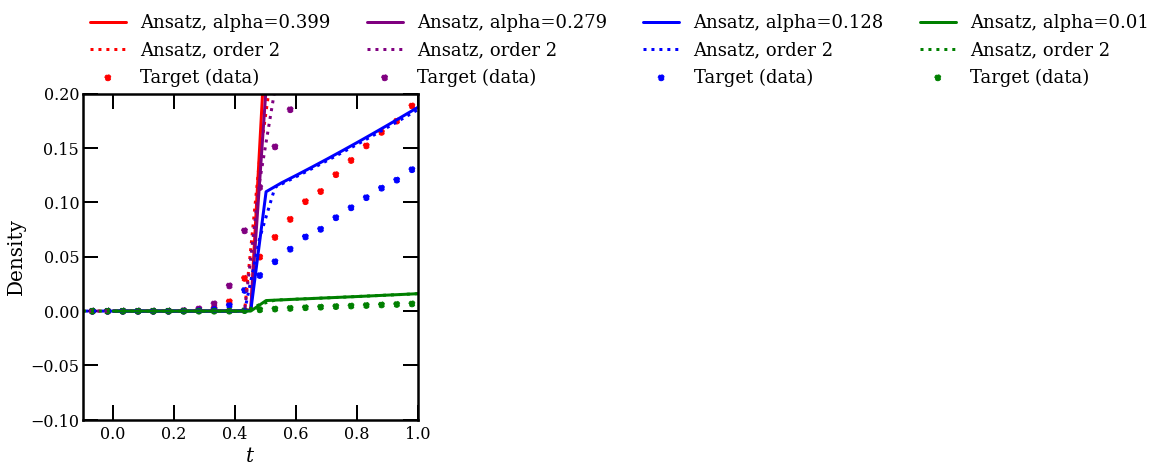

In [8]:

plt.figure(figsize = (6,6))
for i, alpha in enumerate([0.399, 0.279, 0.128, 0.01]):
    alpha_tensor = torch.tensor(alpha, device=device)

    # plot ansatz
    plt.plot(tt.detach().cpu().numpy(),q(tt, alpha_tensor, torch.tensor(g_coeffs_log[-1], device=device), 
                                         torch.tensor(theta_log[-1], device=device), mstar, t_min, t_max, device, factorial_cache_info).detach().cpu().numpy(),
             label=f"Ansatz, alpha={alpha}",color=colors[i],)


      # plot ansatz derivative
    alpha_zero = torch.tensor(1e-12, device=device, requires_grad=True)
    fn = lambda a: q(
        t_bin_centers, a,  torch.tensor(g_coeffs_log[-1], device=device),  torch.tensor(theta_log[-1], device=device), mstar, t_min, t_max, device, factorial_cache_info
    )
    batch_ansatz = get_taylor_expanded_ansatz(fn, alpha_zero, alpha_tensor, order_to_match)



    plt.plot(t_bin_centers.detach().cpu().numpy(),batch_ansatz.detach().cpu().numpy(),label=f"Ansatz, order {order_to_match}",color=colors[i],linestyle="dotted")



    
    if run_toy:
        # plot all-orders solution
        plt.plot(t_bin_centers.detach().cpu().numpy(),t_pdf_toy( alpha_tensor, distribution, t_bin_centers, -1, device).detach() .cpu().numpy(), label="Target (exact)",color=colors[i],linestyle="dashed",)
        # plot-fixed order target
        plt.scatter(  t_bin_centers.detach().cpu().numpy(),get_pdf_toy( alpha_tensor, distribution, t_bin_centers, order_to_match,  device ).detach().cpu()  .numpy(),label=f"Target (order $\\alpha^{args.order_to_match}$)",color=colors[i],s=0.8,)

    else:
        # plot histogram
        loc_data, loc_err = data_dict[alpha]
        #plt.errorbar(t_bin_centers.detach().cpu().numpy(), loc_data.detach().cpu().numpy().reshape(-1,), yerr = loc_err.detach().cpu().numpy().reshape(-1,),  label="Target (data)",  color=colors[i],linestyle="dashed",)
        plt.scatter(t_bin_centers.detach().cpu().numpy(), loc_data.detach().cpu().numpy().reshape(-1,),  label="Target (data)",  color=colors[i],linestyle="dashed",)


plt.legend(loc = (0, 1), ncol = 4)
plt.xlabel("$t$")
plt.ylabel("Density")
plt.xlim(-0.1, 1)
plt.ylim(-0.1, 0.2)
plt.savefig(f"figures/{outfile_name}_results_nice.png", bbox_inches = "tight")

plt.show()

## Plot in x space

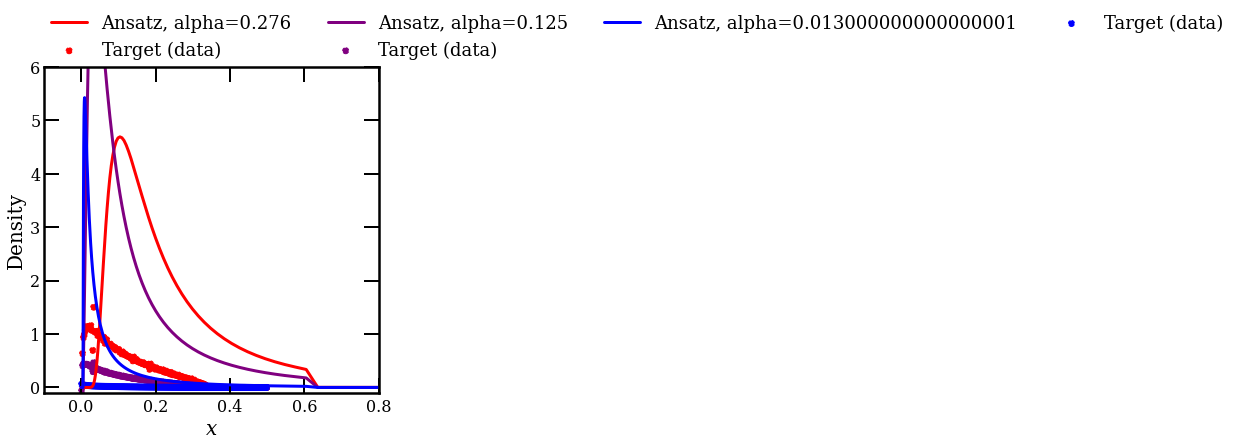

In [24]:
xx = torch.exp(-tt)

jacobian = 1.0 / xx



plt.figure(figsize = (6,6))
for i, alpha in enumerate([0.276, 0.125, 0.013000000000000001]):
    alpha_tensor = torch.tensor(alpha, device=device)

    # plot ansatz
    plt.plot(xx.detach().cpu().numpy(),jacobian*q(tt, alpha_tensor, torch.tensor(g_coeffs_log[-1], device=device), 
                                         torch.tensor(theta_log[-1], device=device), mstar, t_min, t_max, device, factorial_cache_info).detach().cpu().numpy(),
             label=f"Ansatz, alpha={alpha}",color=colors[i],)


      # plot ansatz derivative
    alpha_zero = torch.tensor(1e-12, device=device, requires_grad=True)
    fn = lambda a: q(
        t_bin_centers, a,  torch.tensor(g_coeffs_log[-1], device=device),  torch.tensor(theta_log[-1], device=device), mstar, t_min, t_max, device, factorial_cache_info
    )
    batch_ansatz = get_taylor_expanded_ansatz(fn, alpha_zero, alpha_tensor, order_to_match)



    #plt.plot(t_bin_centers.detach().cpu().numpy(),batch_ansatz.detach().cpu().numpy(),label=f"Ansatz, order {order_to_match}",color=colors[i],linestyle="dotted")



    
    if run_toy:
        # plot all-orders solution
        plt.plot(t_bin_centers.detach().cpu().numpy(),t_pdf_toy( alpha_tensor, distribution, t_bin_centers, -1, device).detach() .cpu().numpy(), label="Target (exact)",color=colors[i],linestyle="dashed",)
        # plot-fixed order target
        plt.scatter(  t_bin_centers.detach().cpu().numpy(),get_pdf_toy( alpha_tensor, distribution, t_bin_centers, order_to_match,  device ).detach().cpu()  .numpy(),label=f"Target (order $\\alpha^{args.order_to_match}$)",color=colors[i],s=0.8,)

    else:
        # plot histogram
        loc_data, loc_err = data_dict_XSPACE[alpha]
        #plt.errorbar(t_bin_centers.detach().cpu().numpy(), loc_data.detach().cpu().numpy().reshape(-1,), yerr = loc_err.detach().cpu().numpy().reshape(-1,),  label="Target (data)",  color=colors[i],linestyle="dashed",)
        plt.scatter(x_bin_centers.detach().cpu().numpy(), loc_data.detach().cpu().numpy().reshape(-1,),  label="Target (data)",  color=colors[i],linestyle="dashed",)


plt.legend(loc = (0, 1), ncol = 4)
plt.xlabel("$x$")
plt.ylabel("Density")
plt.xlim(-0.1, 0.8)
plt.ylim(-0.1, 6)
plt.savefig(f"figures/{outfile_name}_results_nice.png", bbox_inches = "tight")

plt.show()

dict_keys([0.005, 0.009000000000000001, 0.013000000000000001, 0.017, 0.021, 0.025, 0.029, 0.033, 0.037, 0.041, 0.045, 0.049, 0.053, 0.057, 0.061, 0.065, 0.069, 0.073, 0.077, 0.081, 0.085, 0.089, 0.093, 0.097, 0.101, 0.105, 0.109, 0.113, 0.117, 0.121, 0.125, 0.129, 0.133, 0.137, 0.14100000000000001, 0.145, 0.149, 0.153, 0.157, 0.161, 0.165, 0.169, 0.17300000000000001, 0.177, 0.181, 0.185, 0.189, 0.193, 0.197, 0.201, 0.20500000000000002, 0.209, 0.213, 0.217, 0.221, 0.225, 0.229, 0.233, 0.23700000000000002, 0.241, 0.245, 0.249, 0.004, 0.012, 0.02, 0.028, 0.036000000000000004, 0.044, 0.052000000000000005, 0.06, 0.068, 0.076, 0.084, 0.092, 0.1, 0.108, 0.116, 0.124, 0.132, 0.14, 0.148, 0.156, 0.164, 0.17200000000000001, 0.18, 0.188, 0.196, 0.20400000000000001, 0.212, 0.22, 0.228, 0.23600000000000002, 0.244, 0.252, 0.26, 0.268, 0.276, 0.28400000000000003, 0.292, 0.3, 0.308, 0.316, 0.324, 0.332, 0.34, 0.34800000000000003, 0.356, 0.364, 0.372, 0.38, 0.388, 0.396])
